# Taylor Swift Discography: Part II - Discography Statistics

## Introduction

This notebook is the second in a series of notebooks analyzing Taylor Swift's discography; in this notebook, I query data from the [database made in Part I](./01_data_collection.ipynb) and display them by building charts via matplotlib and seaborn.

All SQL queries made in this notebook are available in the [sql folder](./sql).

This notebook uses the modules [`toolkit.py`](./src/toolkit.py) for miscellanious tasks made throughout this notebook.

**Please note this notebook is a work-in-progress and not yet complete.**

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sqlite3 as sql
from matplotlib import rcParams

from src import toolkit

connection = sql.connect('data/taylor_swift.db')
cursor = connection.cursor()

In [2]:
# Dictionaries to define categorical order and color palettes
eras = {
    'Taylor Swift': '#A5C9A5',
    'Fearless': '#F7ED67',
    'Speak Now': '#DE72EC',
    'Red': '#E0374F',
    '1989': '#8ADBFB',
    'reputation': '#746F70',
    'Lover': '#F7B0CC',
    'folklore': '#CDC9C1',
    'evermore': '#C5AC90',
    'Fearless (TV)': '#EFC180',
    'Red (TV)':  '#7A2E39',
    'Midnights': '#242E47',
    'Speak Now (TV)': '#C7A8CB',
    '1989 (TV)': '#B5E5F8',
    'Non-Album Songs': '#BF360C',
    'Other Artist Songs': '#607D8B'
}

credits = {
    'writer': '#6D466B',
    'producer': '#58A4B0',
    'artist': '#FF6B6C'
}

In [3]:
toolkit.install_fonts()
rcParams['font.family'] = 'Lato'
rcParams['figure.dpi'] = 150
rcParams['savefig.dpi'] = 150

## Musical Credits and Collaborators

Over her career, Taylor Swift has worked with numerous writers, producers, and fellow artists to create her musical catalogue, demonstrated by the musical credits on each song. However, some of her albums and overall musical eras are more collaborative efforts than others; while an album may not have many featured artists, it could still be very collaborative in terms of writing or producing. In order to see which musical eras had overall more collaborators than others, I first count the number of writers, producers, and artists per song before summarizing by era. I then calculate the average amount of writers, producers, and artists per song for each era to see which eras (on average) had more writers, producers, and/or artists working on each song than others.

In [4]:
temp_tables = toolkit.sql_to_string('temp_tables.sql')
cursor.executescript(temp_tables)

In [5]:
avg_credit_per_song = toolkit.sql_to_string('avg_credit_per_song.sql')

avg_credit = pd.read_sql(avg_credit_per_song, connection)

toolkit.sort_cat_column(avg_credit, 'era', eras.keys())
avg_credit.head(9)

,era,type,avg_per_song
0,Taylor Swift,writer,2.07
1,Taylor Swift,producer,1.14
2,Taylor Swift,artist,1.00
3,Fearless,writer,1.67
4,Fearless,artist,1.06
5,Fearless,producer,2.00
6,Speak Now,artist,1.06
7,Speak Now,writer,1.11
8,Speak Now,producer,1.89


In [6]:
avg_per_type = avg_credit.groupby('type')['avg_per_song'].mean().sort_values(ascending=False)
avg_per_type

type
writer      2.088125
producer    1.928750
artist      1.153125
Name: avg_per_song, dtype: float64

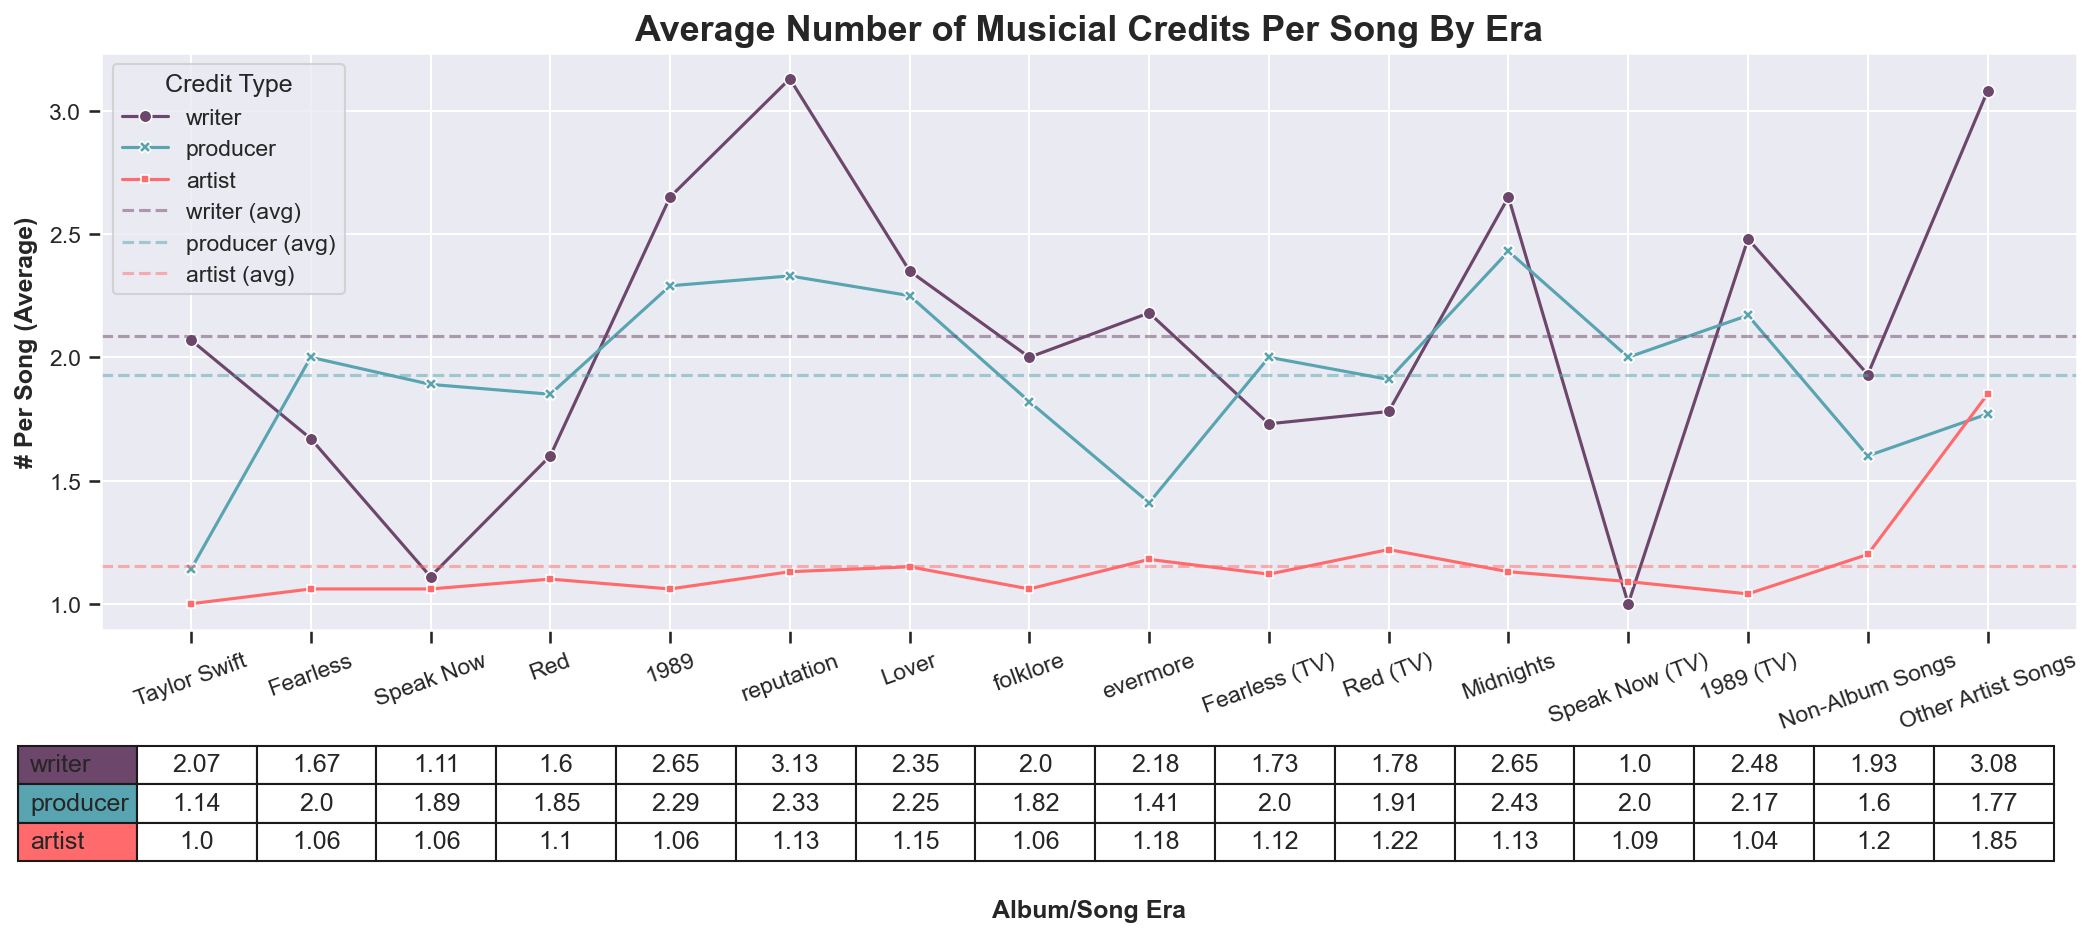

In [7]:
avg_credit_pivot = avg_credit.pivot(columns='era', index='type', values='avg_per_song')
avg_credit_pivot.sort_values('type', ascending=False, inplace=True)
avg_credit_pivot

# Customizing overall chart properties
custom_params = {'ytick.left': True, 
                 'xtick.bottom': True}
credit_palette = sns.color_palette(credits.values())
sns.set_theme(style='darkgrid', rc=custom_params)
fig, ax = plt.subplots(figsize=(17, 5))

# Creating lineplot and drawing average lines
chart = sns.lineplot(avg_credit, x='era', y='avg_per_song', hue='type', style='type', 
             markers=True, dashes=False, ax=ax, palette=credit_palette)
for (type, avg) in avg_per_type.items():
    plt.axhline(y=avg, color=credits[type], linestyle='--', 
                label='{} (avg)'.format(type), alpha=0.5)

# Adding table for point values
plt.table(cellText=avg_credit_pivot.values, cellLoc='center', 
          rowLabels=avg_credit_pivot.index, rowColours=list(credits.values()),
          bbox=(0.018, -0.4, .97, 0.2))

# Customizing axes
plt.title('Average Number of Musicial Credits Per Song By Era', 
          fontweight='bold', fontsize='x-large')
plt.ylabel('# Per Song (Average)', fontweight='bold', fontsize='medium', 
           labelpad=5.5)
plt.xlabel('Album/Song Era', fontweight='bold', fontsize='medium',
           labelpad=80)
plt.legend(title='Credit Type')
ax.tick_params(axis='x', labelrotation=20)

# Saving chart as png
plt.savefig('./figures/charts/avg_credits_per_era.png', bbox_inches='tight')

Through the chart shown above, we get a clearer understanding of which eras were more collaborative in terms of writers, producers, and artists. For instance, both "reputation" and "Midnights" were highly collaborative eras, with the former having the highest average of writers per song (3.13 writers) and the latter having the highest average of producers per song (2.43 producers). Meanwhile, both "Speak Now" and "Speak Now (Taylor's Version)" have the lowest average of 1.11 and 1.0 writers per song respectively, the rerecording being solely written by Taylor herself, and the self-titled "Taylor Swift" has the lowest average of 1.14 producers per song, followed by "evermore" at 1.41 producers. Her collaborations with artists tend to be more steady, many albums having few vocal features, but "Red (Taylor's Version)" boasts the highest average of her studio albums and rerecordings, of 1.22 artists per song. Unsurprisingly, this is surpassed by her collaboration songs on other artists' albums, which have an average artist-per-song of 1.85.

To determine her most and least collaborative eras, we'll look at where eras had all values fall relative the overall means per type (represented by horizontal dash lines). Four eras fall below all three means, making them her least collaborative on average: "Taylor Swift", "Speak Now", "Red", and "folklore." Interestingly, no era has all values fall above the overall means; "Lover" has higher averages for both writers-per-song and producers-per-song, but its average for artists-per-song is equal to the overall mean for artists-per-song. Despite this fact, its values being at-or-above each mean makes it the most collaborative era on average.

## TBA (Work in Progress)

In [8]:
connection.close()